# Generative AI and Prompt Engineering
## A programme by IISc and TalentSprint
### Mini-Project: Medical Q&A using GPT2

## Learning Objectives

At the end of the experiment, you will be able to:

* perform data preprocessing, EDA and feature extraction on the Medical Q&A dataset
* load a pre-trained tokenizer
* finetune a GPT-2 language model for medical question-answering

## Dataset Description

The dataset used in this project is the *Medical Question Answering Dataset* ([MedQuAD](https://github.com/abachaa/MedQuAD/tree/master)). It includes medical question-answer pairs along with additional information, such as the question type, the question *focus*, its UMLS(Unified Medical Language System) details like - Concept Unique Identifier(*CUI*) and Semantic *Type* and *Group*.

To know more about this data's collection, and construction method, refer to this [paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3119-4).

The data is extracted and is in CSV format with below features:

- **Focus**: the question focus
- **CUI**: concept unique identifier
- **SemanticType**
- **SemanticGroup**
- **Question**
- **Answer**

## Grading = 10 Points

## Information

Healthcare professionals often have to refer to medical literature and documents while seeking answers to medical queries. Medical databases or search engines are powerful resources of upto date medical knowledge. However, the existing documentation is large and makes it difficult for professionals to retrieve answers quickly in a clinical setting. The problem with search engines and informative retrieval engines is that these systems return a list of documents rather than answers. Instead, healthcare professionals can use question answering systems to retrieve short sentences or paragraphs in response to medical queries. Such systems have the biggest advantage of generating answers and providing hints in a few seconds.

### Problem Statement

Fine-tune gpt2 model on medical-question-answering-dataset for performing response generation for medical queries.

### **GPT-2**

In recent years, the OpenAI GPT-2 exhibited an impressive ability to write coherent and passionate essays that exceeded what current language models can produce. The GPT-2 wasn't a particularly novel architecture - its architecture is very similar to the **decoder-only transformer**. The GPT2 was, however, a very large, transformer-based language model trained on a massive dataset.

Here, you are going to fine-tune the GPT2 model with the Medical data. Expected result should be that the model will be able to reply to the prompt related medical queries after fine-tuning.

To know more about GPT-2, refer [here](http://jalammar.github.io/illustrated-gpt2/).

### Installing Dependencies

In [1]:
%%capture
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

### <font color="#990000">Restart Session/Runtime</font>

### Import required packages

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import warnings
warnings.filterwarnings('ignore')

In [2]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/MedQuAD.csv
!ls | grep ".csv"

MedQuAD.csv


**Exercise 1: Read the MedQuAD.csv dataset**

**Hint:** `pd.read_csv()`

In [3]:
# Reading MedQuAD questions
pd.set_option("display.max_columns", None)
med_data = pd.read_csv("/content/MedQuAD.csv")
med_data.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
0,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points - Adult acute lymphoblastic leukemi...
1,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [4]:
# Get Data Information
med_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Focus          16398 non-null  object
 1   CUI            15847 non-null  object
 2   SemanticType   15815 non-null  object
 3   SemanticGroup  15847 non-null  object
 4   Question       16412 non-null  object
 5   Answer         16407 non-null  object
dtypes: object(6)
memory usage: 769.4+ KB


### Pre-processing and EDA

**Exercise 2: Perform below operations on the dataset [1 Mark]**

- Handle missing values
- Remove duplicates from data considering `Question` and `Answer` columns

- **Handle missing values**

In [5]:
# We have some unanswered questions in our dataset.
display(med_data[med_data["Answer"].isna()])

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2263,"Emery-Dreifuss muscular dystrophy, dominant type",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2264,"Emery-Dreifuss muscular dystrophy, X-linked",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2400,Familial HDL deficiency,C2931838,T047,Disorders,What is (are) Familial HDL deficiency ?,NaN
2876,HELLP syndrome,C0162739,T047,Disorders,What is (are) HELLP syndrome ?,NaN
6021,X-linked lymphoproliferative syndrome,C0549463,T191,Disorders,What is (are) X-linked lymphoproliferative syn...,NaN


In [6]:
med_data[med_data["CUI"]=="C0410189"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2263,"Emery-Dreifuss muscular dystrophy, dominant type",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2264,"Emery-Dreifuss muscular dystrophy, X-linked",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2265,"Emery-Dreifuss muscular dystrophy, X-linked",C0410189,T047,Disorders,What are the symptoms of Emery-Dreifuss muscul...,What are the signs and symptoms of Emery-Dreif...
7658,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystrophy ?,Emery-Dreifuss muscular dystrophy is a conditi...
7659,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,How many people are affected by Emery-Dreifuss...,X-linked Emery-Dreifuss muscular dystrophy is ...
7660,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,What are the genetic changes related to Emery-...,Mutations in the EMD and LMNA genes cause Emer...
7661,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,Is Emery-Dreifuss muscular dystrophy inherited ?,Emery-Dreifuss muscular dystrophy can have sev...
7662,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,What are the treatments for Emery-Dreifuss mus...,These resources address the diagnosis or manag...


In [7]:
med_data[med_data["CUI"]=="C2931838"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2400,Familial HDL deficiency,C2931838,T047,Disorders,What is (are) Familial HDL deficiency ?,NaN
2401,Familial HDL deficiency,C2931838,T047,Disorders,What are the symptoms of Familial HDL deficien...,What are the signs and symptoms of Familial HD...
7828,familial HDL deficiency,C2931838,T047,Disorders,What is (are) familial HDL deficiency ?,Familial HDL deficiency is a condition charact...
7829,familial HDL deficiency,C2931838,T047,Disorders,How many people are affected by familial HDL d...,"Familial HDL deficiency is a rare disorder, al..."
7830,familial HDL deficiency,C2931838,T047,Disorders,What are the genetic changes related to famili...,Mutations in the ABCA1 gene or the APOA1 gene ...
7831,familial HDL deficiency,C2931838,T047,Disorders,Is familial HDL deficiency inherited ?,Familial HDL deficiency is inherited in an aut...
7832,familial HDL deficiency,C2931838,T047,Disorders,What are the treatments for familial HDL defic...,These resources address the diagnosis or manag...


In [8]:
med_data[med_data["CUI"]=="C0162739"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2876,HELLP syndrome,C0162739,T047,Disorders,What is (are) HELLP syndrome ?,NaN
2877,HELLP syndrome,C0162739,T047,Disorders,What are the symptoms of HELLP syndrome ?,What are the signs and symptoms of HELLP syndr...
2878,HELLP syndrome,C0162739,T047,Disorders,What causes HELLP syndrome ?,What causes HELLP syndrome? Doctors are still ...


In [9]:
med_data[med_data["CUI"]=="C0549463"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
6021,X-linked lymphoproliferative syndrome,C0549463,T191,Disorders,What is (are) X-linked lymphoproliferative syn...,NaN
6022,X-linked lymphoproliferative syndrome,C0549463,T191,Disorders,What are the symptoms of X-linked lymphoprolif...,What are the signs and symptoms of X-linked ly...
11343,X-linked lymphoproliferative disease,C0549463,T191,Disorders,What is (are) X-linked lymphoproliferative dis...,X-linked lymphoproliferative disease (XLP) is ...
11344,X-linked lymphoproliferative disease,C0549463,T191,Disorders,How many people are affected by X-linked lymph...,XLP1 is estimated to occur in about 1 per mill...
11345,X-linked lymphoproliferative disease,C0549463,T191,Disorders,What are the genetic changes related to X-link...,Mutations in the SH2D1A and XIAP genes cause X...
11346,X-linked lymphoproliferative disease,C0549463,T191,Disorders,Is X-linked lymphoproliferative disease inheri...,This condition is generally inherited in an X-...
11347,X-linked lymphoproliferative disease,C0549463,T191,Disorders,What are the treatments for X-linked lymphopro...,These resources address the diagnosis or manag...


In [10]:
# Since we need to be very carefull while answering the medical query, it will be good if drop missing information than
# filling it with the similarity. Although this won't make big impact. And Fill Others with UNK
med_data = med_data.dropna(subset=["Answer"]).fillna("UNK")
med_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 16407 entries, 0 to 16411
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Focus          16407 non-null  object
 1   CUI            16407 non-null  object
 2   SemanticType   16407 non-null  object
 3   SemanticGroup  16407 non-null  object
 4   Question       16407 non-null  object
 5   Answer         16407 non-null  object
dtypes: object(6)
memory usage: 897.3+ KB


- **Remove duplicates from data considering `Question` and `Answer` columns**

In [11]:
# Question and Answer are first required to lower case and we can drop duplicate records.
med_data["Question"] = med_data["Question"].str.lower()
med_data["Answer"] = med_data["Answer"].str.lower()
med_data.drop_duplicates(subset=["Question", "Answer"], inplace=True)
med_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 16359 entries, 0 to 16411
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Focus          16359 non-null  object
 1   CUI            16359 non-null  object
 2   SemanticType   16359 non-null  object
 3   SemanticGroup  16359 non-null  object
 4   Question       16359 non-null  object
 5   Answer         16359 non-null  object
dtypes: object(6)
memory usage: 894.6+ KB


**Exercise 3: Display the category name, and the number of records belonging to top 100 categories of `Focus` column [1 Mark]**

In [12]:
# Total categories in Focus column
print("Total no of categories : ",med_data["Focus"].nunique())

Total no of categories :  5126


In [13]:
# Displaying the distinct categories of Focus column and the number of records belonging to each category
# (Top 100 only)
print("The number of records belonging to top 100 categories of Focus column : ")
top_100_focus = med_data[["Focus"]].value_counts()[:100]
top_100_focus.head(10)

The number of records belonging to top 100 categories of Focus column : 


,count
Focus,
Breast Cancer,53
Prostate Cancer,43
Stroke,35
Skin Cancer,34
Alzheimer's Disease,30
Lung Cancer,29
Colorectal Cancer,29
Heart Attack,28
Heart Failure,28


In [55]:
top_100_focus.tail(10)

,count
Focus,
Medullary Sponge Kidney,11
Urinary Retention,11
Vesicoureteral Reflux,11
Laron syndrome,11
IgA Nephropathy,11
Camurati-Engelmann disease,11
Danon disease,11
Klinefelter syndrome,11
Porphyria,11


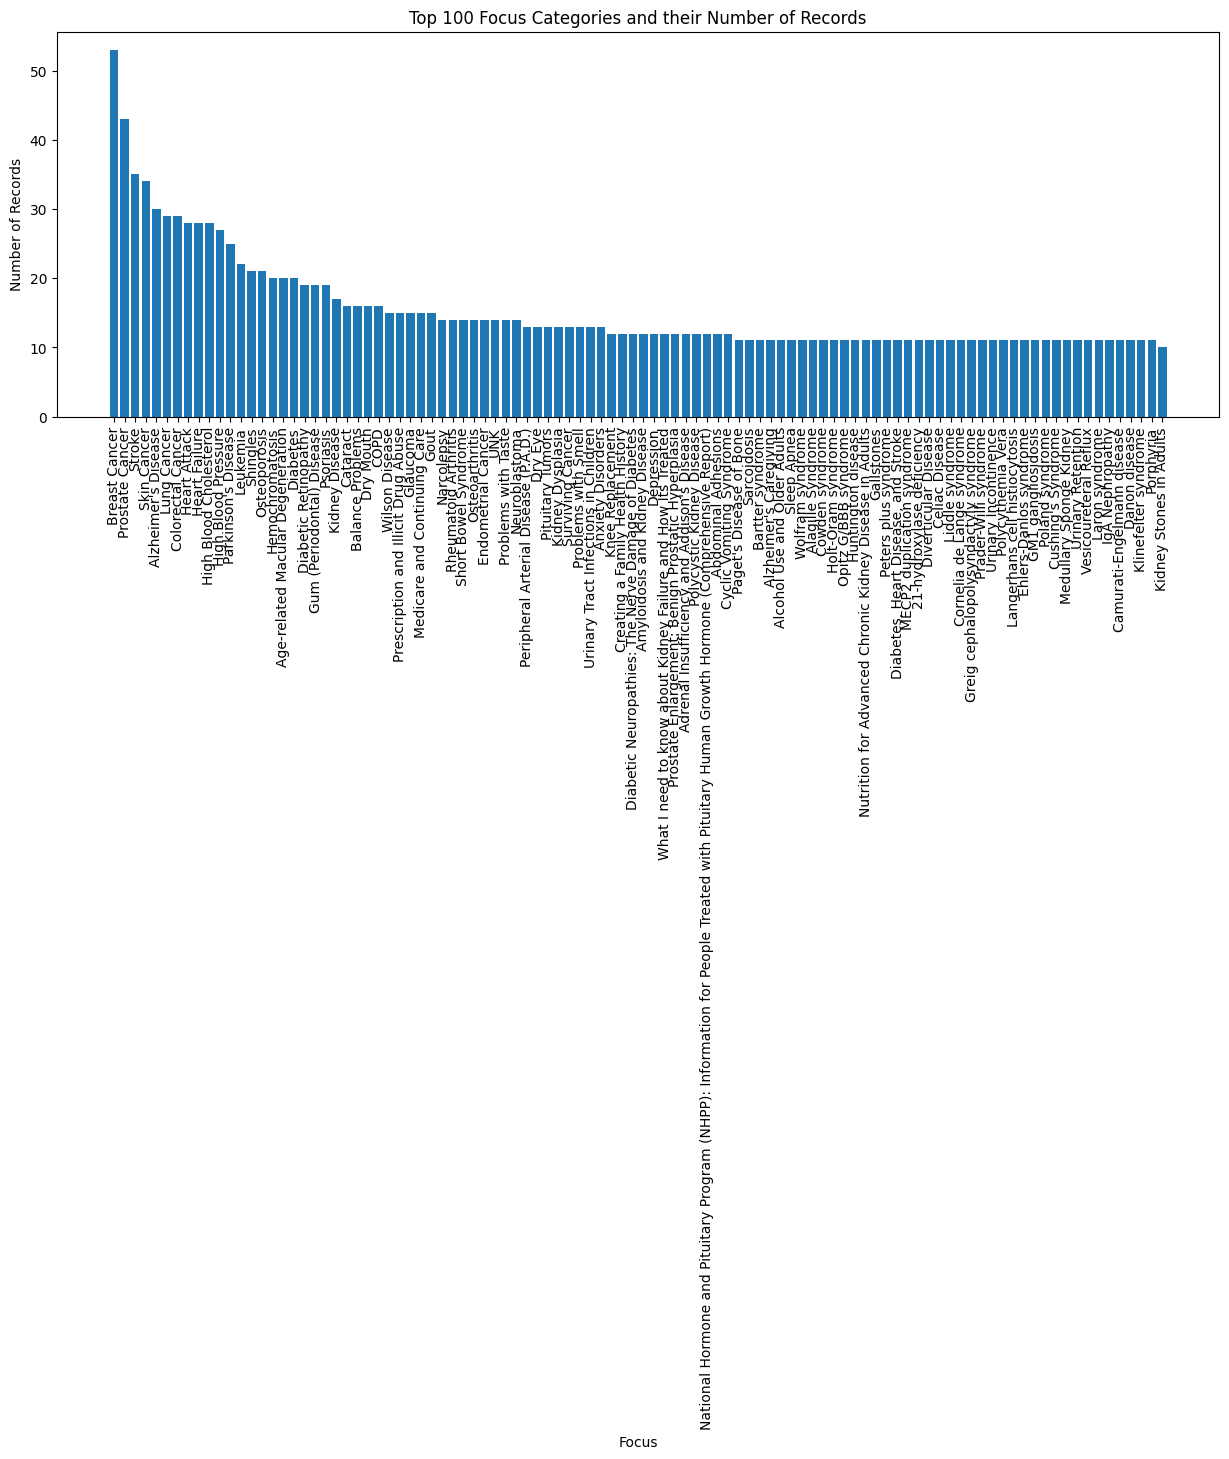

In [54]:
# prompt: plot top_100_focus

plt.figure(figsize=(15, 5))
plt.bar(top_100_focus.index.get_level_values(0), top_100_focus.values)
plt.xticks(rotation=90)
plt.xlabel("Focus")
plt.ylabel("Number of Records")
plt.title("Top 100 Focus Categories and their Number of Records")
plt.show()


In [14]:
# Top 100 Focus categories names
top_100_focus.index.get_level_values(0)

Index(['Breast Cancer', 'Prostate Cancer', 'Stroke', 'Skin Cancer',
       'Alzheimer's Disease', 'Lung Cancer', 'Colorectal Cancer',
       'Heart Attack', 'Heart Failure', 'High Blood Cholesterol',
       'High Blood Pressure', 'Parkinson's Disease', 'Leukemia', 'Shingles',
       'Osteoporosis', 'Hemochromatosis', 'Age-related Macular Degeneration',
       'Diabetes', 'Diabetic Retinopathy', 'Gum (Periodontal) Disease',
       'Psoriasis', 'Kidney Disease', 'Cataract', 'Balance Problems',
       'Dry Mouth', 'COPD', 'Wilson Disease',
       'Prescription and Illicit Drug Abuse', 'Glaucoma',
       'Medicare and Continuing Care', 'Gout', 'Narcolepsy',
       'Rheumatoid Arthritis', 'Short Bowel Syndrome', 'Osteoarthritis',
       'Endometrial Cancer', 'UNK', 'Problems with Taste', 'Neuroblastoma',
       'Peripheral Arterial Disease (P.A.D.)', 'Dry Eye', 'Pituitary Tumors',
       'Kidney Dysplasia', 'Surviving Cancer', 'Problems with Smell',
       'Urinary Tract Infections in Child

### Create Training and Validation set

**Exercise 4: Create training and validation set [1 Mark]**

- Consider 4 samples per `Focus` category, for each top 100 categories, from the dataset (It will give 400 samples for training)

- Consider 1 sample per `Focus` category (different from training set), for each top 100 categories, from the dataset (It will give 100 samples for validation)

In [15]:
DATA_FOR_TRAINING = pd.DataFrame()
for category in top_100_focus.index.get_level_values(0):
    DATA_FOR_TRAINING = pd.concat([DATA_FOR_TRAINING, med_data[med_data["Focus"]==category].sample(5, random_state=42)])

TRAIN_SET, VALIDATION_SET = train_test_split(DATA_FOR_TRAINING, test_size=0.2, random_state=42)

print(TRAIN_SET.shape)
print(VALIDATION_SET.shape)

(400, 6)
(100, 6)


### Pre-process `Question` and `Answer` text

**Exercise 5: Perform below tasks:  [1 Mark]**

- Combine `Question` and `Answer` for train and validation data as shown below:
    - sequence = *'\<question\>' + question-text + '\<answer\>' + answer-text + '\<end\>'*

- Join the combined text using '\n' into a single string for training and validation separately

- Save the training and validation strings as separate text files

- **Combine Question and Answer for train and val data**

In [16]:
# Combine Questions and Answers for train and val data
## sequence = '<question> ' + question + ' <answer> ' + answer + ' <end>'

def combine_question_answer(row):
    return "<question>" + row["Question"].strip() + "<answer>" + row["Answer"].strip() + " <end>"

TRAIN_SET["sequence"] = TRAIN_SET.apply(combine_question_answer, axis=1)
VALIDATION_SET["sequence"] = VALIDATION_SET.apply(combine_question_answer, axis=1)

In [56]:
TRAIN_SET.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer,sequence
12689,Diabetic Neuropathies: The Nerve Damage of Dia...,C0161479,T037,Disorders,what are the treatments for diabetic neuropath...,the first treatment step is to bring blood glu...,<question>what are the treatments for diabetic...
2223,Ehlers-Danlos syndrome,C0013720,T019,Disorders,is ehlers-danlos syndrome inherited ?,is ehlers-danlos syndrome inherited? the inher...,<question>is ehlers-danlos syndrome inherited ...
574,Skin Cancer,C0007114,T191,Disorders,who is at risk for skin cancer? ?,skin color and being exposed to sunlight can i...,<question>who is at risk for skin cancer? ?<an...
14719,Sleep Apnea,C0037315,T047,Disorders,what are the treatments for sleep apnea ?,there are a variety of treatments for sleep ap...,<question>what are the treatments for sleep ap...
13430,Alagille Syndrome,C0085280,T019,Disorders,how to prevent alagille syndrome ?,scientists have not yet found a way to prevent...,<question>how to prevent alagille syndrome ?<a...


In [76]:
TRAIN_SET["sequence"].loc[12689]

'<question>what are the treatments for diabetic neuropathies: the nerve damage of diabetes ?<answer>the first treatment step is to bring blood glucose levels within the normal range to help prevent further nerve damage. blood glucose monitoring, meal planning, physical activity, and diabetes medicines or insulin will help control blood glucose levels. symptoms may get worse when blood glucose is first brought under control, but over time, maintaining lower blood glucose levels helps lessen symptoms. good blood glucose control may also help prevent or delay the onset of further problems. as scientists learn more about the underlying causes of neuropathy, new treatments may become available to help slow, prevent, or even reverse nerve damage. as described in the following sections, additional treatment depends on the type of nerve problem and symptom. pain relief doctors usually treat painful diabetic neuropathy with oral medications, although other types of treatments may help some peop

In [57]:
VALIDATION_SET.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer,sequence
12901,Gallstones,C0008350,T047,Disorders,what is (are) gallstones ?,the biliary tract consists of the gallbladder ...,<question>what is (are) gallstones ?<answer>th...
15339,Osteoporosis,C0029456,T047,Disorders,what is (are) osteoporosis ?,consider talking to your doctor about being ev...,<question>what is (are) osteoporosis ?<answer>...
12665,"Diabetes, Heart Disease, and Stroke",C0038454,T047,Disorders,"what are the treatments for diabetes, heart di...",treatment for heart disease includes meal plan...,<question>what are the treatments for diabetes...
14553,Narcolepsy,C0027404,T047,Disorders,what research (or clinical trials) is being do...,the national institute of neurological disorde...,<question>what research (or clinical trials) i...
15467,Psoriasis,C0033860,T047,Disorders,what are the treatments for psoriasis ?,there are many types of treatments. many are m...,<question>what are the treatments for psoriasi...


- **Join the combined text using '\n' into a single string for training and validation separately**

In [17]:
# Train and Validation text for all Q&As

train_text = "\n".join(TRAIN_SET["sequence"].tolist())
validation_text = "\n".join(VALIDATION_SET["sequence"].tolist())

- **Save the training and validation strings as text files**

In [18]:
# Save the training and validation data as text files

with open("train.txt", "w") as f:
    f.write(train_text)

with open("validation.txt", "w") as f:
    f.write(validation_text)

**Exercise 6: Load pre-trained GPT2Tokenizer**

- Use checkpoint = "gpt2"

**Hint:** `GPT2Tokenizer.from_pretrained(...)`

In [19]:
# Set up the tokenizer
checkpoint = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

**Exercise 7: Tokenize train and validation data [1 Mark]**

- Use the loaded pre-trained tokenizer
- Use training and validation data saved in text files

**Hint:**

`from datasets import load_dataset`

`dataset = load_dataset("text", data_files={...})`

In [20]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("text", data_files={"train": "train.txt", "validation": "validation.txt"})

# Tokenize Data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=1024)

tokenized_dataset = dataset.map(
    tokenize_function, batched=True,
    batch_size=8, remove_columns=["text"]
    )
tokenized_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 100
    })
})

**Exercise 8: Create a DataCollator object**

**Hint:** `DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="pt")`

Data collators are objects that:

- will form a batch by using a list of dataset elements as input
- may apply some processing (like padding)

One of the data collators, `DataCollatorForLanguageModeling`, can also apply some random data augmentation (like random masking) on the formed batch.

<br>

`DataCollatorForLanguageModeling` is a data collator used for language modeling. Inputs are dynamically padded to the maximum length of a batch if they are not all of the same length.

Parameters:

- ***tokenizer:*** The tokenizer used for encoding the data.
- ***mlm*** (bool, optional, default=True): Whether or not to use masked language modeling.
    - If set to False, the labels are the same as the inputs with the padding tokens ignored (by setting them to -100).
    - Otherwise, the labels are -100 for non-masked tokens and the value to predict for the masked token.
- ***return_tensors*** (str): The type of Tensor to return. Allowable values are “np”, “pt” and “tf” for numpy array, pytorch tensor, and tensorflow tensor respectively.

To know more about `DataCollatorForLanguageModeling` parameters, refer [here](https://huggingface.co/docs/transformers/v4.32.0/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling).

In [21]:
# Create a Data collator object
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="pt")

**Exercise 9: Load pre-trained GPT2LMHeadModel**

**Hint:** `GPT2LMHeadModel.from_pretrained(...)`

In [22]:
# Set up the model
model = GPT2LMHeadModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

**Exercise 10: Fine-tune GPT2 Model [2 Mark]**

- Specify training arguments and create a TrainingArguments object (Use 30 epochs)

- Train a GPT-2 model using the provided training arguments

- Save the resulting trained model and tokenizer to a specified output directory

In [23]:
# Set up the training arguments

model_output_path = "/content/gpt_model"

training_args = TrainingArguments(
    output_dir=model_output_path,
    num_train_epochs=30,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    remove_unused_columns=False
    )

In [24]:
# Train the model

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"]
)

trainer.train()

Step,Training Loss
500,2.242100
1000,1.706200
1500,1.302800
2000,1.053500
2500,0.822300
3000,0.677000
3500,0.562300
4000,0.477200
4500,0.416200
5000,0.380200


TrainOutput(global_step=6000, training_loss=0.8601163202921549, metrics={'train_runtime': 1919.7764, 'train_samples_per_second': 6.251, 'train_steps_per_second': 3.125, 'total_flos': 2670405587712000.0, 'train_loss': 0.8601163202921549, 'epoch': 30.0})

In [25]:
# Save the model
trainer.save_model(model_output_path)

# Save the tokenizer
tokenizer.save_pretrained(model_output_path)

('/content/gpt_model/tokenizer_config.json',
 '/content/gpt_model/special_tokens_map.json',
 '/content/gpt_model/vocab.json',
 '/content/gpt_model/merges.txt',
 '/content/gpt_model/added_tokens.json')

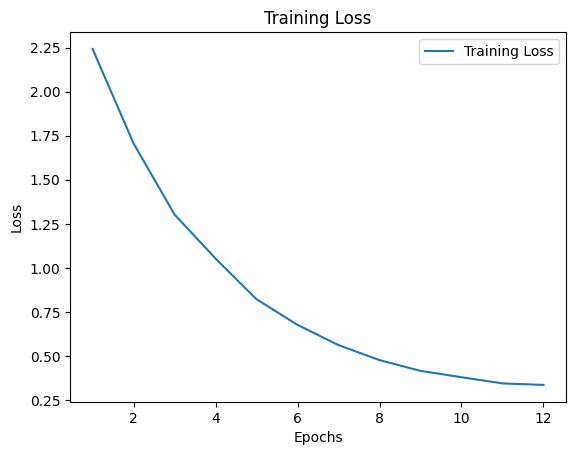

In [58]:
# prompt: plot the training and validation loss

import matplotlib.pyplot as plt

# Assuming you have the training and validation loss stored in a list or dictionary
# Replace 'trainer.state.log_history' with your actual loss data
training_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'eval_loss' not in entry]

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
# plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


**Exercise 11: Test Model with user input prompts [2 Mark]**

- Create `generate_response()` function that takes a trained *model*, *tokenizer*, and a *prompt* string as input and generates a response using the GPT-2 model

- Test it with some user input prompts

In [59]:
def generate_response(model, tokenizer, prompt, max_length=200):
  """
  Generates a response using the GPT-2 model.

  Args:
    model: The trained GPT-2 model.
    tokenizer: The tokenizer used for the model.
    prompt: The input prompt string.

  Returns:
    The generated response string.
  """
  input_ids = tokenizer.encode(prompt, return_tensors='pt')
  attention_mask = torch.ones(input_ids.shape, dtype=torch.long)
  output = model.generate(input_ids, attention_mask=attention_mask, max_length=max_length)
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  return response


In [30]:
# Load the fine-tuned model and tokenizer

fine_tune_model = GPT2LMHeadModel.from_pretrained(model_output_path)
fine_tune_tokenizer = GPT2Tokenizer.from_pretrained(model_output_path)

In [60]:
# Testing with a sample prompt 1

prompt = "What precautions to take for a healthy life?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What precautions to take for a healthy life? talk with your doctor about what you should do to help prevent a serious condition from developing. also, check the list to find out if you have any questions about your rights and protections. <end> <end>here are questions to ask when considering a family health care provider. - is this a family member's first time health care provider? - what services do the providers provide? - how long have the services been in the community? - what is the health condition for which they provide the services? - will the provider provide the services my relative or friend needs? - will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? 

In [61]:
# Testing with a sample prompt 2

prompt = "What precaution to take during cancer"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What precaution to take during cancer treatment? talk with your doctor about what you should do and what you should not do. also, be sure to talk with your family members and friends about what you can do to help. read or listen to books about the importance of family life and the importance of cancer treatment. read or listen to books about the importance of family life and the importance of cancer treatment. be sure to speak with your doctor about what you should do and what you should not do. read or listen to books about the importance of family life and the importance of cancer treatment. read or listen to books about the importance of family life and the importance of cancer treatment. if you smoke, quit. your doctor can help you plan a healthy and successful future. he or she can suggest ways you can reduce or stop smoking, and you can take steps to keep your lungs healthy and free from cancer. read or listen to books about the importance of family life and the importance of ca

**Exercise 12: Compare the performance of a *GPT2 model* with the *GPT2 model fine-tuned* on MedQuAD data [1 Mark]**

- Load another pre-trained GPT2LMHeadModel and do not fine-tune it

- To generate response using the untuned model, pass it as a parameter to `generate_response()` function

- Test both models (fine-tuned and untuned) with below user input prompts:

    - "What precautions to take for a healthy life?"
    - "What to do after being diagnosed with cancer?"
    - "What to do when feeling sick?"

In [33]:
# Load a pre-trained GPT2 model, do not finetune it with MedQuAD data

untuned_model = GPT2LMHeadModel.from_pretrained("gpt2")
untuned_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [77]:
# Testing with finetuned model: prompt 1

prompt = "What precautions to take for a healthy life?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What precautions to take for a healthy life? talk with your doctor about what you should do to help prevent a serious condition from developing. also, check the list to find out if you have any questions about your rights and protections. <end> <end>here are questions to ask when considering a family health care provider. - is this a family member's first time health care provider? - what services do the providers provide? - how long have the services been in the community? - what is the health condition for which they provide the services? - will the provider provide the services my relative or friend needs? - will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? will the provider provide the services my relative or friend does not need? 

In [78]:
# Testing with untuned model: prompt 1

prompt = "What precautions to take for a healthy life?"
response = generate_response(untuned_model, untuned_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What precautions to take for a healthy life?\n\nThe following are some of the most common questions you'll hear from your doctor or nurse about your health.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause"

In [69]:
# Testing with finetuned model: prompt 2

prompt = "What to do after being diagnosed with cancer?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What to do after being diagnosed with cancer? - talk with your doctor about what you can do to help. - see a video on coping with cancer. - visit the following resources to learn more about coping with cancer. - nihsenior cancer screening: information for people with medullary sponge cancer nihsenior cancer screening: information for people with medullary sponge cancer talk with your doctor about what you can do to help. see a video on coping with cancer. nihsenior cancer screening: information for people with medullary sponge cancer visit the following resources to learn more about coping with cancer. nihsenior cancer screening: information for people with medullary sponge cancer may be difficult to obtain because there are many factors that contribute to the risk of developing cancer. talk with your doctor about what you can do to help. nihsenior cancer screening: information for people with medullary sponge cancer may be difficult to obtain because there are many factors that contr

In [70]:
# Testing with untuned model: prompt 2

prompt = "What to do after being diagnosed with cancer?"
response = generate_response(untuned_model, untuned_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What to do after being diagnosed with cancer?\n\nThe first step is to get your doctor's approval for a treatment.\n\nIf you have a cancer diagnosis, you may need to get a second opinion.\n\nIf you have a cancer diagnosis, you may need to get a second opinion. If you have a cancer diagnosis, you may need to get a third opinion.\n\nIf you have a cancer diagnosis, you may need to get a third opinion. If you have a cancer diagnosis, you may need to get a fourth opinion.\n\nIf you have a cancer diagnosis, you may need to get a fourth opinion. If you have a cancer diagnosis, you may need to get a fifth opinion.\n\nIf you have a cancer diagnosis, you may need to get a fifth opinion. If you have a cancer diagnosis, you may need to get a sixth opinion.\n\nIf you have a cancer diagnosis, you may need to get a sixth opinion. If you have"

In [71]:
# Testing with finetuned model: prompt 3

prompt = "What to do when feeling sick?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What to do when feeling sick? - ask your doctor about any changes in your breathing, including how often you breathe, and what changes in your breathing do you notice. - if you have any questions about your breathing, feel free to ask. - if you have any questions about diet and weight, talk with your doctor about what you can eat and plan meals. - if you are feeling cranky, take a break from work to relax. - if you are feeling tired, take a break from activities you used to be able to take part in. - for more information on exercise and the health benefits of it, go to the national heart, lung, and blood institute\'s "your guide to healthy living." - if you are feeling overwhelmed, take a break from work to relax. if you are feeling tired, take a break from activities you used to be able to take part in. for more information on exercise and the health benefits of it, go to the national heart, lung, and'

In [72]:
# Testing with untuned model: prompt 3

prompt = "What to do when feeling sick?"
response = generate_response(untuned_model, untuned_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What to do when feeling sick?\n\nThe first thing you should do is to get your body to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick"